# 04. PyTorch Custom Datasets 

We used some datasets with PyTorch before.

How to use own data?

One of the ways to do so is using custom datasets.

**Resources**: 
- Book version on learnpytorch.io
- Notebook on Daniel's Github

## Domain libraries

Depending on what is working on, vision, text, audio, recommendations.... -> PyTorch domain libs


## Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# PyTorch 1.10+ is needed
print(f"Torch version: {torch.__version__}")
print(f"Torch build cuda version: {torch.version.cuda}")

Torch version: 2.5.1
Torch build cuda version: 11.8


In [2]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_22:08:44_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [4]:
!nvidia-smi

Mon Nov 18 05:39:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8             12W /   10W |     157MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get some data

The dataset is a subset of the food101 dataset, which starts with 101 different classes of food. The following dataset is reduced to three classes and 1000 images.

It's important to try on a small scale and then increase the scale when necessary.

In [13]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else: 
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and suhsi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, suhsi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data\pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [14]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [15]:
walk_through_dir(extract_folder)

There are 2 directories and 0 images in 'Food101_pizza_steak_sushi'.
There are 3 directories and 0 images in 'Food101_pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'Food101_pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'Food101_pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'Food101_pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'Food101_pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'Food101_pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'Food101_pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'Food101_pizza_steak_sushi\train\sushi'.


In [16]:
# Setup train and test directories
train_dir = os.path.join(extract_folder, "train")
test_dir = os.path.join(extract_folder, "test")

train_dir, test_dir

('Food101_pizza_steak_sushi\\train', 'Food101_pizza_steak_sushi\\test')

### 2.1 Visualize an image

Let's write some code to:
1. Get all of the image's paths
2. Pick a random image path using Python's `random.choice`
3. Get the imgage class name with `pathlit.Path.parent.stem`
4. Open the image with Pillow
5. Show the image and print metadata

In [17]:
image_path

WindowsPath('data/pizza_steak_sushi')

data\pizza_steak_sushi\test\sushi\2394442.jpg
sushi
Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height x width: (512, 408)


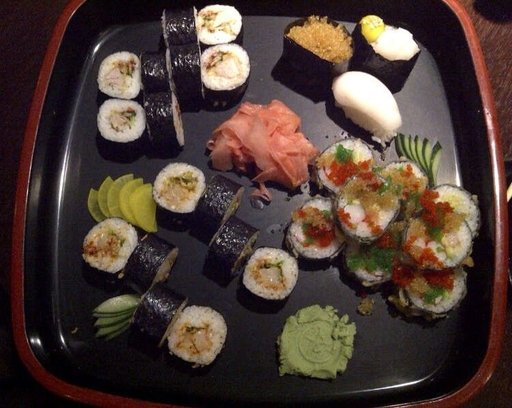

In [47]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get  imga paths list
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get the class name
image_class = random_image_path.parent.stem
print(image_class)

# 4. OPen image
img = Image.open(random_image_path)

# 5. Print metadata of image
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height x width: {img.size}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(407.5), np.float64(-0.5))

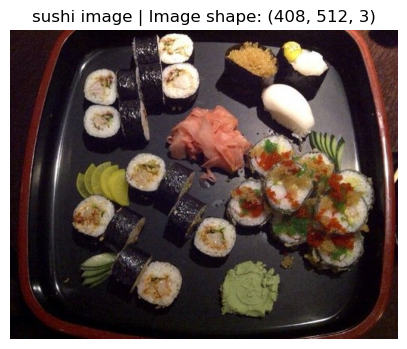

In [ ]:
import numpy as np
import random

# Visualize an image with matplotlib
import matplotlib.pyplot as plt

img_as_array = np.array(img)
# Erst als array, bekommt man die Anzahl der Farbkanäle über shape

plt.figure(figsize=(5,5))
plt.imshow(img_as_array)
plt.title(f"{image_class} image | Image shape: {img_as_array.shape}")
plt.axis(False)


## 3. Transforming data

Before one can use the image data with PyTorch:
1. Turn the target data into tensors (in this case a numerical representation of the images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data` and `Dataloader`

In [65]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transform`

Transform help, to get the images ready to be used with a model/perform data augmentation

In [66]:
# Write a transform to turn images into tensors
data_transform = transforms.Compose([ # nn.sezuential würde auch funktionieren
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [72]:
data_transform(img)

tensor([[[0.1294, 0.1373, 0.1412,  ..., 0.0863, 0.0824, 0.0824],
         [0.1255, 0.1373, 0.1412,  ..., 0.0902, 0.0902, 0.0902],
         [0.1294, 0.1412, 0.1333,  ..., 0.1059, 0.0980, 0.1137],
         ...,
         [0.0157, 0.0196, 0.0157,  ..., 0.1294, 0.1373, 0.1412],
         [0.0275, 0.0275, 0.0275,  ..., 0.1255, 0.1373, 0.1333],
         [0.0314, 0.0314, 0.0275,  ..., 0.1137, 0.1294, 0.1255]],

        [[0.0588, 0.0588, 0.0667,  ..., 0.0392, 0.0431, 0.0431],
         [0.0588, 0.0549, 0.0667,  ..., 0.0392, 0.0431, 0.0353],
         [0.0510, 0.0627, 0.0627,  ..., 0.0471, 0.0471, 0.0392],
         ...,
         [0.0039, 0.0078, 0.0078,  ..., 0.0667, 0.0667, 0.0667],
         [0.0118, 0.0118, 0.0118,  ..., 0.0706, 0.0706, 0.0667],
         [0.0118, 0.0157, 0.0196,  ..., 0.0667, 0.0667, 0.0667]],

        [[0.0667, 0.0667, 0.0667,  ..., 0.0706, 0.0706, 0.0745],
         [0.0784, 0.0784, 0.0863,  ..., 0.0941, 0.0902, 0.0863],
         [0.0824, 0.0863, 0.0941,  ..., 0.0941, 0.1059, 0.

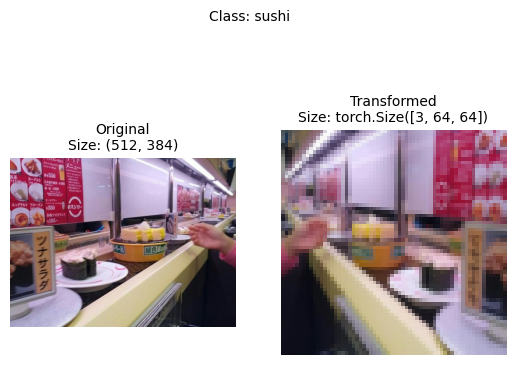

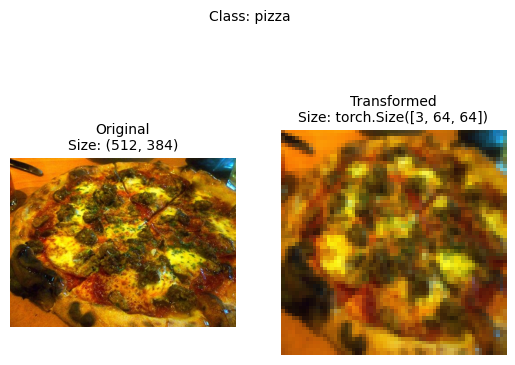

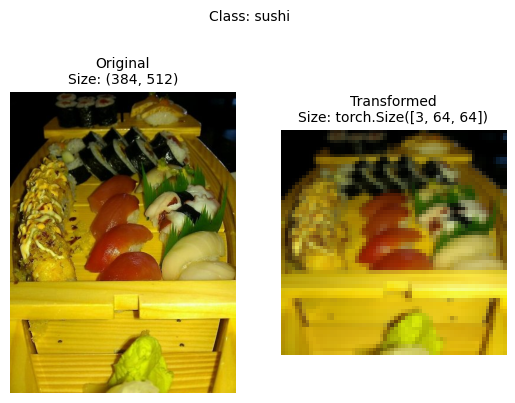

In [111]:
def plot_transformed_images(
    image_paths: list, 
    transform, 
    n=3, 
    seed=None):
    """
    Picks n random images from image_paths and displays them with transform applied.
    """

    if seed:
        random.seed(seed)
    
    random_image_paths = random.sample(image_paths, k=n)
    
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2,)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}", fontsize=10)
            ax[0].axis(False)

            transformed_image = transform(f)
            ax[1].imshow(transformed_image.permute(1, 2, 0))
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}", fontsize=10)
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=10)

plot_transformed_images(
    image_paths=image_path_list, 
    transform=data_transform, 
    n=3,
    seed=None)

## 4. Option 1: Loading image data using `ImageFolder`

One can load image classification data using `torchvision.datasets.ImageFolder`

In [112]:
# Use image folders to create datasets
from torchvision.datasets import ImageFolder

train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,
    target_transform=None
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform,
    target_transform=None
)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: Food101_pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: Food101_pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [113]:
# Get class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [115]:
# Get class names as dict
class_names_dict = train_data.class_to_idx
class_names_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [116]:
# Check the lengths of the datasets
len(train_data), len(test_data)

(225, 75)